## Problem Set 2
Olivia Natan


We are going to be using data on health care expenditures to do some plotting and fitting of a few different distributions from the Gamma family using MLE.

In [1]:
# Imports:
import pandas as pd
import numpy as np
import scipy.stats as sts
import scipy.special as spc
import scipy.optimize as opt
import matplotlib.pyplot as mpl
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
import distributions
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Part (a)

In [2]:
# let's bring in our data:
costs = np.loadtxt('clms.txt')
# let's also check for the range of the data
print(np.percentile(costs,(1,5,25,50,75)))
print(np.percentile(costs,(80,85,90,95,99,99.9)))

[   5.      14.75    74.45   172.21   451.535]
[   582.268         803.043        1207.17         2343.181        9987.5144
  35672.06224001]


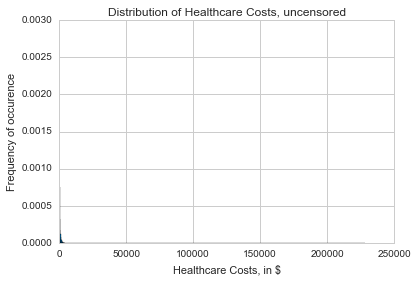

In [3]:
# Histogram 1: distribution of all costs with 1000 bins, height =freq
mpl.hist(costs,1000,normed=True)
mpl.xlabel('Healthcare Costs, in $')
mpl.ylabel('Frequency of occurence')
mpl.title('Distribution of Healthcare Costs, uncensored')

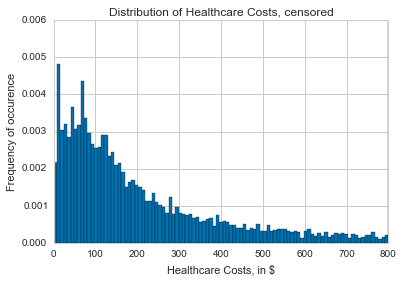

In [4]:
# Histogram 2: Distribution of all costs with 100 bins, height=freq
# Then we censor at 800$
costs_censored = pd.DataFrame(costs)
costs_censored.columns = ['costs']
costs_censored['censored'] = costs_censored['costs']
costs_censored.loc[costs_censored.costs>800,'censored']=808 
mpl.hist(np.array(costs_censored['censored']),100,normed=True)
# this is a hacky way of retaining the true frequencies but also having 100 bars exactly: using 100 breaks creates 101 bars
mpl.xlim(0,800)
mpl.ylim(0,0.006)
mpl.xlabel('Healthcare Costs, in $')
mpl.ylabel('Frequency of occurence')
mpl.title('Distribution of Healthcare Costs, censored')

## Comparing our 2 histograms

There are certainly reasons to prefer each histogram. If I'm an insurance company, I should find both pictures informative. The uncensored distribution tells us that there are some customers who are in the very highest cost area - and more or less what the observed maximum is. However, it is clear that this is a tiny percentage of the insured.

This is where the 2nd histogram is more informative. 800$ is more or less the 85th percentile of the data, and we can learn about the shape of most of the mass of the observed data. 

## Part (b)

Our initial guesses for the gamma distribution we are fitting are: $$\beta_0 = \frac{E(x)}{Var(x)}$$ and $$\alpha_0 = \frac{E(x)}{\beta_0}$$

$${\displaystyle f(x;\alpha ,\beta )={\frac {x^{\alpha -1}e^{-x/\beta }}{\beta ^{\alpha }\Gamma (\alpha )}}\quad {\text{ for }}x\geq 0{\text{ and }}\alpha ,\beta >0.}$$
$$E(X) = \alpha\beta$$
$$Var(x) = \alpha\beta^2$$

In [5]:
# Now we will fit a gamma distribution to this data
# Let's set our initial guesses as above:
beta_0 = np.var(costs)/np.mean(costs)
alpha_0 = np.mean(costs)/beta_0
print(alpha_0, beta_0)

(0.032872796694206986, 21911.064702753894)


Let's check that we are using the right parameterization of the gamma distribution to use the one from the package:

In [87]:
#check we have the right interpretation of the package parameterization
test_x=100
print(sts.gamma.pdf(test_x,alpha_0,loc=0,scale=beta_0))
print((test_x**(alpha_0 -1))*np.exp(-test_x/beta_0)/((beta_0**alpha_0)*spc.gamma(alpha_0)))

0.000279107227578
0.000279107227578


In [86]:
#Let's check the gamma function works
print(distributions.log_lik_gamma(costs,alpha_0,beta_0))
print(sts.gamma.logpdf(costs,alpha_0,loc=0,scale=beta_0).sum())

-93555.3939035
-93555.3939035


In [11]:
# Let's optimize:
def gamma_crit(params, *args):
    alpha_0,beta_0 = params
    costs = args
    log_lik_val = distributions.log_lik_gamma(costs, alpha_0,beta_0)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [12]:
import scipy.optimize as opt
params_init = np.array([alpha_0,beta_0])
mle1_args = (costs)
results = opt.minimize(gamma_crit, params_init, args=(mle1_args),bounds=((0,None),(0,None)),tol=1e-12)
alpha_MLE,beta_MLE = results.x

In [13]:
results

  status: 0
 success: True
    nfev: 36
     fun: 82076.451605624199
       x: array([  2.21755454e-01,   2.19110647e+04])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([ 0.03201421,  0.09167707])
     nit: 9

In [14]:
print('Estimates:')
print("Alpha: ", alpha_MLE)
print('Beta: ', beta_MLE)
print('LL: ', -results.fun)

Estimates:
('Alpha: ', 0.22175545428396778)
('Beta: ', 21911.064698808907)
('LL: ', -82076.451605624199)


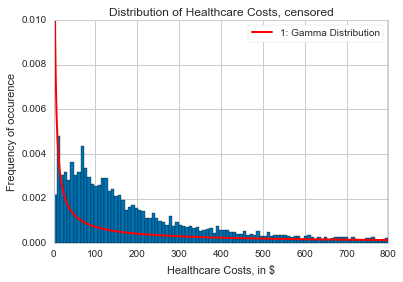

In [15]:
dist_pts = np.linspace(0, 800, 800)
mpl.hist(np.array(costs_censored['censored']),100,normed=True)
# this is a hacky way of retaining the true frequencies but also having 100 bars exactly: using 100 breaks creates 101 bars
mpl.xlim(0,800)
mpl.plot(dist_pts, sts.gamma.pdf(dist_pts, alpha_MLE, loc=0,scale=beta_MLE),
         linewidth=2, color='r',label='1: Gamma Distribution')
mpl.ylim(0,0.01)
mpl.xlabel('Healthcare Costs, in $')
mpl.ylabel('Frequency of occurence')
mpl.title('Distribution of Healthcare Costs, censored')
mpl.legend(loc='upper right',frameon=True,fancybox=True)

This isn't looking like the right distribution for our data: it has too flat/small a tail...

We want something that has a peak farther from the origin and bigger tails

How precise are these estimates? Let's compute some quick SE's - though note the optimizing method we used doesn't produce a hessian since we used the solvers that allow bounds. 

## Part (c)
We want to fit a generalized gamma now:

$$f(x;\alpha,\beta,m)={\frac  {(m/\beta^{\alpha})x^{{\alpha-1}}e^{{-(x/\beta)^{m}}}}{\Gamma (\alpha/m)}}$$

In [16]:
def gen_gamma_crit(params,*args):
    alpha_0,beta_0,m_0 = params
    costs = args
    log_lik_val = distributions.log_lik_gen_gamma(costs,alpha_0,beta_0,m_0)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [85]:
# Checking our functions to make sure we get the same ll for sample points
print(distributions.log_lik_gen_gamma(1,alpha_MLE,beta_MLE,1))
print(sts.gengamma.logpdf(1,alpha_MLE,1,loc=0,scale=beta_MLE))

-3.63125050149
-3.63125050149


In [21]:
initvals_2 = results.x[0], results.x[1], np.exp(0)
initvals_2

(0.22175545428396778, 21911.064698808907, 1.0)

In [22]:
import scipy.optimize as opt
params_init_gen = initvals_2
mle2_args = costs
results2 = opt.minimize(gen_gamma_crit, params_init_gen, args=(mle2_args),bounds=((0,None),(0,None),(0,None)))
alpha_MLE2,beta_MLE2,m_MLE2 = results2.x

In [23]:
results2

  status: 0
 success: True
    nfev: 36
     fun: 82076.446465899789
       x: array([  2.22283437e-01,   2.19110644e+04,   9.97615654e-01])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([-0.10477379,  0.09167707, -0.09167707])
     nit: 4

In [24]:
print('Estimates:')
print("Alpha: ", alpha_MLE2)
print('Beta: ', beta_MLE2)
print('m: ',m_MLE2)
print('LL: ', -results2.fun)

Estimates:
('Alpha: ', 0.22228343705991607)
('Beta: ', 21911.064391235406)
('m: ', 0.99761565414571518)
('LL: ', -82076.446465899789)


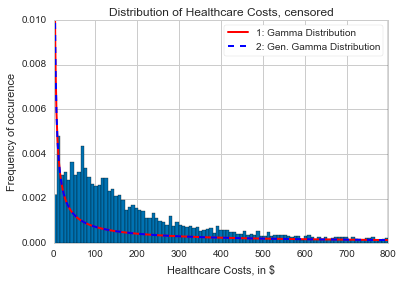

In [25]:
dist_pts = np.linspace(0, 800, 800)
mpl.hist(np.array(costs_censored['censored']),100,normed=True)
# this is a hacky way of retaining the true frequencies but also having 100 bars exactly: using 100 breaks creates 101 bars
mpl.xlim(0,800)
mpl.plot(dist_pts, sts.gamma.pdf(dist_pts, alpha_MLE, loc=0,scale=beta_MLE),
         linewidth=2, color='r',label='1: Gamma Distribution')
mpl.plot(dist_pts, sts.gengamma.pdf(dist_pts, alpha_MLE2, m_MLE2,loc=0,scale=beta_MLE2),
         linewidth=2,ls='dashed', color='b',label='2: Gen. Gamma Distribution')
mpl.ylim(0,0.01)
mpl.xlabel('Healthcare Costs, in $')
mpl.ylabel('Frequency of occurence')
mpl.title('Distribution of Healthcare Costs, censored')
mpl.legend(loc='upper right',frameon=True,fancybox=True)

## Part (D)
We now want to estimate the 4-parameter GB2 function
Recall that 
$$GG(x;\alpha,\beta,m)={\frac  {(m/\beta^{\alpha})x^{{\alpha-1}}e^{{-(x/\beta)^{m}}}}{\Gamma (\alpha/m)}}$$
 
We also take 
$$GB2(y;a,b,p,q)={\frac {|a|y^{ap-1}}{b^{ap}B(p,q)(1+(y/b)^{a})^{p+q}}}$$
Where $$GG(y;a,d ,p)=\lim _{q\rightarrow \infty }GB2(y,a,b=q^{1/a}d ,p,q)={\frac {|a|y^{ap-1}e^{-(y/d )^{a}}}{d ^{a}\Gamma (p)}}$$ 
Basically, we will take the following as starting values for our GB2: $$a=m^0$$ $$b=q^{1/m^0}*\beta^0$$ $$p=\alpha^0$$ $$q=q^0$$

In [36]:
aa_0 = m_MLE2
qq_0 = 1000000
bb_0 = (qq_0**(1/m_MLE2))*beta_MLE2
pp_0 = alpha_MLE2

In [38]:
initvals3 = bb_0,pp_0,qq_0,aa_0
initvals3

(22646638226.869671, 0.22228343705991607, 1000000, 0.99761565414571518)

In [37]:
def gen_beta2_crit(params,*args):
    bb_0,pp_0,qq_0,aa_0= params
    costs = args
    log_lik_val = distributions.log_lik_gen_beta_2(costs,bb_0,pp_0,qq_0,aa_0)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [39]:
# checking the module gives us the right LL using parameter conversions
print(distributions.log_lik_gen_beta_2(costs,bb_0,pp_0,qq_0,aa_0))
print(results2.fun)

-82076.4473053
82076.4464659


In [40]:
import scipy.optimize as opt
params_init_gb2 = initvals3
mle3_args = costs
results3 = opt.minimize(gen_beta2_crit, params_init_gb2, args=(mle3_args),bounds=((0,None),(0,None),(0,None),(0,None)),tol=1e-12)
bb_MLE3,pp_MLE3,qq_MLE3,aa_MLE3 = results3.x

In [41]:
results3

  status: 0
 success: True
    nfev: 215
     fun: 76923.390258492989
       x: array([  2.26466382e+10,   7.81306378e-01,   9.99999382e+05,
         8.04757513e-01])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([     0.        ,    884.31988843,   1977.95015993,  16463.14776735])
     nit: 9

In [42]:
print('Estimates:')
print("b: ", bb_MLE3)
print('p: ', pp_MLE3)
print('q: ', qq_MLE3)
print('a: ', aa_MLE3)
print('LL: ', -results3.fun)

Estimates:
('b: ', 22646638226.869671)
('p: ', 0.78130637829116434)
('q: ', 999999.38208846387)
('a: ', 0.80475751306219945)
('LL: ', -76923.390258492989)


In [43]:
# pdf function for graphing:
def gb2_pdf(xvals,bb,pp,qq,aa):
    pdf_vals = (np.abs(aa)*(xvals**(aa*pp -1)))/((bb**(aa*pp))*spc.beta(pp,qq)*((1+((xvals/bb)**aa))**(pp+qq)))
    return pdf_vals

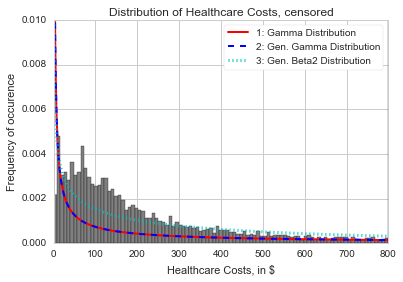

In [83]:
dist_pts = np.linspace(0, 800, 800)
mpl.hist(np.array(costs_censored['censored']),100,normed=True,color='grey')
# this is a hacky way of retaining the true frequencies but also having 100 bars exactly: using 100 breaks creates 101 bars
mpl.xlim(0,800)
mpl.plot(dist_pts, sts.gamma.pdf(dist_pts, alpha_MLE, loc=0,scale=beta_MLE),
         linewidth=2, color='r',label='1: Gamma Distribution')
mpl.plot(dist_pts, sts.gengamma.pdf(dist_pts, alpha_MLE2, m_MLE2,loc=0,scale=beta_MLE2),
         linewidth=2,ls='dashed', color='b',label='2: Gen. Gamma Distribution')
mpl.plot(dist_pts, gb2_pdf(dist_pts, bb_MLE3, pp_MLE3,qq_MLE3,aa_MLE3),
         linewidth=3,ls='dotted', color='c',label='3: Gen. Beta2 Distribution')
mpl.ylim(0,0.01)
mpl.xlabel('Healthcare Costs, in $')
mpl.ylabel('Frequency of occurence')
mpl.title('Distribution of Healthcare Costs, censored')
mpl.legend(loc='upper right',frameon=True,fancybox=True)
mpl.savefig('PS2_Natan_all_est.png',dpi=400)

We did OK here - the tails are fatter, but we're still not getting a nice hump, could this be a problem with the optimization?

## Part (e)
Perform likelihood ratio tests.

Recall that our test statistic is:
$$ LR(\tilde{\theta}|\hat{\theta}_{MLE}) = 2\Bigl(\ln\ell(\hat{\theta}_{MLE}) - \ln\ell(\tilde{\theta})\Bigr) \sim \chi^2(p) $$
Where $\tilde{\theta}$ is the constrained value we are testing 

Note! If we evaluate the nested estimates with converted parameters to the nesting distribution, the LL is the same! We don't need to recalculate.

In [61]:
# first, let's compare the simple gamma disribution against the full GB2
# Then we'll compare the generalized gamma against GB2
ll_gamma = -results.fun
ll_gen_gamma = -results2.fun
ll_gb2 = -results3.fun
def lr_stat(ll_theta_tilde,ll_theta_hat):
    ts= 2*(ll_theta_hat - ll_theta_tilde)
    return ts
def pctile_chisq(ts,pp):
    pctile = sts.chi2.cdf(ts,pp,loc=0,scale=1)
    return pctile

In [82]:
lr_gamma = lr_stat(ll_gamma,ll_gb2)
lr_gen_gamma = lr_stat(ll_gen_gamma,ll_gb2)
print(lr_gamma, ' Test statistic for gamma vs gb2')
print(lr_gen_gamma, ' Test statistic for generalized gamma vs gb2')
print(sts.chi2.ppf(0.95,4,loc=0,scale=1), ' 95th percentile of the reference distribution')
print('Quantile from Gamma vs GB2 test statistic: probability of observing a less extreme value',pctile_chisq(lr_gamma,4))
print('Quantile from Gen Gamma vs GB2 test statistic: probability of observing a less extreme value',pctile_chisq(lr_gen_gamma,4))

(10306.12269426242, ' Test statistic for gamma vs gb2')
(10306.1124148136, ' Test statistic for generalized gamma vs gb2')
(9.487729036781154, ' 95th percentile of the reference distribution')
('Quantile from Gamma vs GB2 test statistic: probability of observing a less extreme value', 1.0)
('Quantile from Gen Gamma vs GB2 test statistic: probability of observing a less extreme value', 1.0)


## Part (f)
Since we don't have a closed form solution for the GB2 cumulative distribution function, we need to approximate integrating the PDF at the true values up to 1,000 dollars and subtract from 1 to get the probability of having a claim over that amount.

We also will do the same to compare to the 2-parameter gamma from part b

In [88]:
import scipy.integrate as scint
def gb2_fit(x):
    return gb2_pdf(x,bb_MLE3, pp_MLE3,qq_MLE3,aa_MLE3)
pr_under_1000_gb2 = scint.quad(gb2_fit,0,1000)
pr_over_1000_gb2 = 1-(pr_under_1000_gb2[0]-pr_under_1000_gb2[1])
print('Probability of a claim over 1000 dollars: ',pr_over_1000_gb2)

('Probability of a claim over 1000 dollars: ', 0.2170481815523665)


In [89]:
#there is a closed form for the Gamma CDF, but it itself requires integrals for lower incomplete gamma function
# good news: our package has it!
def gamma_fit_cdf(x):
    return sts.gamma.cdf(x,alpha_MLE,loc=0,scale=beta_MLE)
pr_over_1000_gamma = 1-gamma_fit_cdf(1000)
print('Probability of a claim over 1000 dollars: ',pr_over_1000_gamma)

('Probability of a claim over 1000 dollars: ', 0.45195995035988368)


We can see that the better fit on the lower area of the distribution of the gb2 fitted distribution meant this estimationmore poorly captured the downside risk for the insurance firm - thus suggesting the slightly better fit from the 4-parameter generalized beta 2 on the lower end of the distribution meant that it put less probability farther out in the tails.

Actually - let's check the empirical probability - looks like both fits vastly overestimate the size of the tails. 

In [91]:
costs_censored['over_1000'] = 1*(costs_censored['costs']>1000)
print("Probability we observe a claim over 1000 dollars: ",costs_censored['over_1000'].mean())

('Probability we observe a claim over 1000 dollars: ', 0.12261041529334213)
